# Introduction
In this notebook, we are learning how search systems (like Google!) decide which results to show first when we type a question.

We’ll use the MS MARCO dataset, which has:

Queries → questions asked by real people

Documents → small pieces of text that may or may not answer those questions

Labels → information about whether a document is relevant to a query

Our job is to:

Train models that can understand which documents are relevant.

Retrieve (find) the most relevant documents for a query.

Evaluate how well our system is doing using metrics like nDCG and Recall.

In [1]:
!pip install -q faiss-cpu sentence-transformers pytorch-lightning torch beir scikit-learn matplotlib pyyaml tyro tqdm rich


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.8/304.8 kB 30.7 MB/s eta 0:00:00


# Understanding the Dataset
We load the MS MARCO dataset using Hugging Face’s load_dataset() function.
The dataset contains:

corpus: a collection of millions of documents (text snippets)

queries: the search questions

qrels: a table that tells which documents are relevant to which query

We join these together so that for each query we know which documents are relevant (label = 1) and which are not relevant (label = 0).

Think of this like having a big table:
| Query                      | Document                          | Label |
| -------------------------- | --------------------------------- | ----- |
| “what is a solar eclipse?” | “A solar eclipse happens when...” | 1     |
| “what is a solar eclipse?” | “Solar energy can be used for...” | 0     |


In [2]:
!pip install -q datasets sentence-transformers

from datasets import load_dataset
import pandas as pd

# 1️⃣ Load all 3 components
corpus_ds  = load_dataset("mteb/msmarco", "corpus")["corpus"]
queries_ds = load_dataset("mteb/msmarco", "queries")["queries"]
qrels_ds   = load_dataset("mteb/msmarco")["train"]   # ← the qrels table you saw above

print("Corpus sample:", corpus_ds[0])
print("Queries sample:", queries_ds[0])
print("Qrels sample:", qrels_ds[0])

# 2️⃣ Convert to lookup dictionaries
corpus_dict = {c["_id"]: c["text"] for c in corpus_ds}
query_dict  = {q["_id"]: q["text"] for q in queries_ds}

# 3️⃣ Join by IDs to build (query, document, label)
records = []
for r in qrels_ds:
    qid, did, score = r["query-id"], r["corpus-id"], r["score"]
    if qid in query_dict and did in corpus_dict:
        label = 1 if score > 0 else 0
        records.append((query_dict[qid], corpus_dict[did], label))

df = pd.DataFrame(records, columns=["query", "document", "label"])
print(f"✅ Built {len(df):,} pairs")
print(df.sample(5))

# 4️⃣ Optionally save for Cross-Encoder training
df.to_parquet("/content/msmarco_pairs.parquet")
print("✅ Saved to /content/msmarco_pairs.parquet")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

corpus.jsonl:   0%|          | 0.00/3.43G [00:00<?, ?B/s]

Generating corpus split:   0%|          | 0/8841823 [00:00<?, ? examples/s]

queries.jsonl:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

Generating queries split:   0%|          | 0/509962 [00:00<?, ? examples/s]

qrels/train.jsonl:   0%|          | 0.00/32.4M [00:00<?, ?B/s]

dev.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/532751 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/7437 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9260 [00:00<?, ? examples/s]

Corpus sample: {'_id': '0', 'title': '', 'text': 'The presence of communication amid scientific minds was equally important to the success of the Manhattan Project as scientific intellect was. The only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly meant; hundreds of thousands of innocent lives obliterated.'}
Queries sample: {'_id': '1185869', 'text': ')what was the immediate impact of the success of the manhattan project?'}
Qrels sample: {'query-id': '1185869', 'corpus-id': '0', 'score': 1.0}
✅ Built 532,751 pairs
                                                    query  \
417805               what age are middle school students?   
283963                                what is a pms color   
154681  what percentage of efficiency has a machine be...   
71805                                    what is humility   
50204           what company owns lays potato chip brand'   

                                             

# Building the Bi-Encoder (Retriever)

We use the SentenceTransformer model (msmarco-MiniLM-L6-v3) to turn each document into a vector — a long list of numbers that captures its meaning.

Then, we build a FAISS index — like a big library search engine for these vectors.
When a query comes in, FAISS quickly finds the most similar document vectors.

So in short:

Each document → vector (via SentenceTransformer)

Query → vector

Compare them → find documents that are most similar

This is called dense retrieval.

In [3]:
!pip install -q faiss-cpu sentence-transformers accelerate bitsandbytes

from sentence_transformers import SentenceTransformer
import faiss, numpy as np, os, json, torch
from tqdm import tqdm

# 1️⃣ Load a small manageable subset (for debugging / demo)
corpus_path = "/content/data/raw/msmarco/corpus.jsonl"
MAX_DOCS = 1000_000  # ✅ Start small; increase once everything works

docs = []
if os.path.exists(corpus_path):
    print("📂 Loading corpus from:", corpus_path)
    with open(corpus_path) as f:
        for i, line in enumerate(f):
            data = json.loads(line)
            docs.append(data.get("text", ""))
            if len(docs) >= MAX_DOCS:
                break
else:
    from datasets import load_dataset
    corpus_ds = load_dataset("mteb/msmarco", "corpus")["corpus"]
    docs = [c["text"] for c in corpus_ds.select(range(MAX_DOCS))]

print(f"📚 Loaded {len(docs):,} documents")

# 2️⃣ Load model with fp16 + GPU optimization
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer("sentence-transformers/msmarco-MiniLM-L6-v3", device=device)

# use faster half-precision on GPU
model = model.half()

# 3️⃣ Encode with big batches and pre-allocation
batch_size = 512 if device == "cuda" else 64
embeddings = np.empty((len(docs), 384), dtype=np.float32)

print(f"⚡ Encoding with batch_size={batch_size} on {device}")

for start in tqdm(range(0, len(docs), batch_size)):
    batch = docs[start:start + batch_size]
    embs = model.encode(
        batch,
        batch_size=batch_size,
        convert_to_numpy=True,
        normalize_embeddings=True,
        show_progress_bar=False
    )
    embeddings[start:start + len(embs)] = embs

print(f"✅ Encoded {len(embeddings):,} embeddings, shape={embeddings.shape}")

# 4️⃣ Build FAISS index (cosine similarity)
index = faiss.IndexFlatIP(embeddings.shape[1])
index.add(embeddings)
print(f"✅ Added {index.ntotal:,} embeddings to FAISS index")

# 5️⃣ Save
os.makedirs("/content/data/indices", exist_ok=True)
faiss.write_index(index, "/content/data/indices/msmarco_flat.index")
print("💾 Saved index → /content/data/indices/msmarco_flat.index")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 14.1 MB/s eta 0:00:00
📚 Loaded 1,000,000 documents


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

⚡ Encoding with batch_size=512 on cuda


100%|██████████| 1954/1954 [15:19<00:00,  2.13it/s]


✅ Encoded 1,000,000 embeddings, shape=(1000000, 384)
✅ Added 1,000,000 embeddings to FAISS index
💾 Saved index → /content/data/indices/msmarco_flat.index


# Building a BM25 Baseline (Lexical Retriever)

BM25 is an old-school search method that just counts word overlaps.
If the words in your query appear often in a document, BM25 gives it a high score.
It’s fast, simple, and still surprisingly strong.

We use rank_bm25 to:

Tokenize all documents (split into lowercase words)

Compute scores for each query

Rank documents by their BM25 scores

This helps us compare how the dense retriever (vectors) performs against a lexical retriever (word counts).

In [6]:
!pip install -q rank-bm25 datasets tqdm

In [7]:
from datasets import load_dataset
import numpy as np
from rank_bm25 import BM25Okapi
from tqdm import tqdm

# 1️⃣ Load directly from Hugging Face
corpus_ds  = load_dataset("mteb/msmarco", "corpus")["corpus"]
queries_ds = load_dataset("mteb/msmarco", "queries")["queries"]

docs = [c["text"] for c in corpus_ds.select(range(20_000))]   # ⚡subset for Colab speed
queries = {q["_id"]: q["text"] for q in queries_ds.select(range(200))}

print(f"📚 Corpus docs: {len(docs):,} | Queries: {len(queries):,}")

# 2️⃣ Tokenize corpus & build BM25
tokenized_corpus = [d.lower().split() for d in docs]
bm25 = BM25Okapi(tokenized_corpus)
print("✅ BM25 index built!")

# 3️⃣ Retrieve top-k
top_k = 10
results = {}
for qid, qtext in tqdm(queries.items()):
    scores = bm25.get_scores(qtext.lower().split())
    top_n = np.argsort(scores)[::-1][:top_k]
    results[qid] = {str(i): float(scores[i]) for i in top_n}

# 4️⃣ Inspect one query
qid = list(results.keys())[0]
print(f"\n🔍 Example query: {queries[qid]}")
for doc_id, score in list(results[qid].items())[:3]:
    print(f"  doc#{doc_id} → score={score:.4f}")


📚 Corpus docs: 20,000 | Queries: 200
✅ BM25 index built!


100%|██████████| 200/200 [00:13<00:00, 14.36it/s]


🔍 Example query: )what was the immediate impact of the success of the manhattan project?
  doc#0 → score=40.1421
  doc#2 → score=38.8961
  doc#7 → score=34.2317


In [8]:
from rank_bm25 import BM25Okapi
from datasets import load_dataset
import numpy as np
from tqdm import tqdm

# 1️⃣ Load corpus + queries from Hugging Face
corpus_ds  = load_dataset("mteb/msmarco", "corpus")["corpus"]
queries_ds = load_dataset("mteb/msmarco", "queries")["queries"]

docs = [c["text"] for c in corpus_ds.select(range(20_000))]      # subset for Colab speed
queries = {q["_id"]: q["text"] for q in queries_ds.select(range(200))}

print(f"📚 Corpus: {len(docs):,} | Queries: {len(queries):,}")

# 2️⃣ Tokenize corpus and build BM25 index
tokenized_corpus = [d.lower().split() for d in docs]
bm25 = BM25Okapi(tokenized_corpus)
print("✅ BM25 index built!")

# 3️⃣ Retrieve top-k results
top_k = 10
results = {}
for qid, qtext in tqdm(queries.items(), desc="BM25 Search"):
    scores = bm25.get_scores(qtext.lower().split())
    top_n = np.argsort(scores)[::-1][:top_k]
    results[qid] = {str(i): float(scores[i]) for i in top_n}

# 4️⃣ Example output
qid = list(results.keys())[0]
print(f"\n🔍 Example query: {queries[qid]}")
for doc_id, score in list(results[qid].items())[:3]:
    print(f"  doc#{doc_id} → score={score:.2f}")

📚 Corpus: 20,000 | Queries: 200
✅ BM25 index built!


BM25 Search: 100%|██████████| 200/200 [00:06<00:00, 29.11it/s]


🔍 Example query: )what was the immediate impact of the success of the manhattan project?
  doc#0 → score=40.14
  doc#2 → score=38.90
  doc#7 → score=34.23


In [9]:
import torch, pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Lightning Cross-Encoder
class CrossEncoderLTR(pl.LightningModule):
    def __init__(self, model_name='cross-encoder/ms-marco-MiniLM-L-6-v2', lr=2e-5):
        super().__init__()
        self.save_hyperparameters()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)

    def forward(self, q, d):
        enc = self.tokenizer(q, d, truncation=True, padding=True,
                             return_tensors='pt', max_length=256).to(self.device)
        return self.model(**enc).logits.squeeze(-1)

    def training_step(self, batch, _):
        out = self(batch['q'], batch['d'])
        loss = torch.nn.functional.mse_loss(out, batch['y'])
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)


In [10]:
!mkdir -p src


In [11]:
%%writefile src/models_ce.py
import torch, pytorch_lightning as pl
from transformers import AutoTokenizer, AutoModelForSequenceClassification

class CrossEncoderLTR(pl.LightningModule):
    def __init__(self, model_name='cross-encoder/ms-marco-MiniLM-L-6-v2', lr=2e-5):
        super().__init__()
        self.save_hyperparameters()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)

    def forward(self, q, d):
        enc = self.tokenizer(q, d, truncation=True, padding=True,
                             return_tensors='pt', max_length=256).to(self.device)
        return self.model(**enc).logits.squeeze(-1)

    def training_step(self, batch, _):
        out = self(batch['q'], batch['d'])
        loss = torch.nn.functional.mse_loss(out, batch['y'])
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)


Writing src/models_ce.py


In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# Custom dataset for query-document pairs
class PairDataset(Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return {
            'q': row['query'],
            'd': row['document'],
            'y': torch.tensor(row['label'], dtype=torch.float)
        }


In [13]:
# Load your MS MARCO (query, doc, label) pairs
df = pd.read_parquet("/content/msmarco_pairs.parquet")

# Use a smaller subset for Colab training speed
df = df.sample(50_000, random_state=42).reset_index(drop=True)

# 90/10 split
split = int(0.9 * len(df))
train_df = df.iloc[:split]
val_df   = df.iloc[split:]

# Wrap in our dataset
train_ds = PairDataset(train_df)
val_ds   = PairDataset(val_df)

# Create DataLoaders
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_dl   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)

print(f"✅ Train: {len(train_ds):,} | Val: {len(val_ds):,}")


✅ Train: 45,000 | Val: 5,000


In [14]:
from src.models_ce import CrossEncoderLTR
import pytorch_lightning as pl

model = CrossEncoderLTR(model_name='cross-encoder/ms-marco-MiniLM-L-6-v2', lr=2e-5)

trainer = pl.Trainer(
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    max_epochs=2,
    precision='16-mixed',
    log_every_n_steps=10
)

trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.
I

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


# What Are We Measuring? (nDCG & Recall)

After retrieval, we need to check how good our results are.

We use two important metrics:

🟩 nDCG@k (Normalized Discounted Cumulative Gain)

Measures how good the ranking order is.

Gives more credit if relevant documents appear at the top.

Perfect ranking → nDCG = 1.0

Random ranking → lower nDCG

🟨 Recall@k

Measures how many relevant documents were retrieved within the top k results.

Example: if there are 5 relevant docs and we find 4 of them in the top 50 → Recall@50 = 0.8.

In [15]:
import numpy as np

# ---  Probabilistic Position-Based Model (PBM)  ---
class PBM:
    def __init__(self, eta: float = 1.6):
        """
        eta controls how fast the examination probability decays with rank.
        Larger eta -> users rarely view deep results.
        """
        self.eta = eta

    def exam_prob(self, rank: int) -> float:
        """Probability that a user examines the result at rank r (0-indexed)."""
        return 1.0 / ((rank + 1) ** self.eta)

    def click(self, rel: bool, rank: int) -> bool:
        """
        Simulate whether a user clicks a result at given rank.
        rel=True means relevant document; rel=False otherwise.
        """
        p_exam = self.exam_prob(rank)
        p_click = p_exam * (0.9 if rel else 0.1)   # 90 % CTR if relevant, 10 % if not
        return np.random.rand() < p_click


# ---  Inverse Propensity Scoring (IPS)  ---
def ips(relevances, ranks, clicks, propensities):
    """
    Compute IPS-weighted average click metric.
      relevances : list of 0/1 labels
      ranks       : list of ranks (0-indexed)
      clicks      : list of simulated clicks (True/False)
      propensities: pre-computed exam probabilities for each rank
    """
    weighted_clicks = [
        c / (propensities[r] + 1e-9)
        for c, r in zip(clicks, ranks)
    ]
    return np.mean(weighted_clicks)


In [16]:
# Example relevance labels for 10 docs (1 = relevant)
rels  = [1, 1, 0, 1, 0, 0, 1, 0, 0, 0]
ranks = list(range(len(rels)))

pbm = PBM(eta=1.6)
prop = [pbm.exam_prob(r) for r in ranks]
clicks = [pbm.click(rel, r) for rel, r in zip(rels, ranks)]

print("Exam probs:", np.round(prop, 3))
print("Clicks:", clicks)
print("IPS-weighted metric:", ips(rels, ranks, clicks, prop))


Exam probs: [1.    0.33  0.172 0.109 0.076 0.057 0.044 0.036 0.03  0.025]
Clicks: [True, True, False, False, False, False, False, False, False, False]
IPS-weighted metric: 0.4031433122831209


In [18]:
from sentence_transformers import SentenceTransformer, CrossEncoder, losses, InputExample
from torch.utils.data import DataLoader
import torch, pandas as pd

# 1️⃣ Load teacher (CrossEncoder) and student (BiEncoder)
teacher = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', device='cuda')
student = SentenceTransformer('all-MiniLM-L6-v2')

# 2️⃣ Load a sample dataset (for Colab speed)
df = pd.read_parquet("/content/msmarco_pairs.parquet").sample(20_000, random_state=42)

# 3️⃣ Build distillation examples
train_examples = []
for _, row in df.iterrows():
    q, d = row["query"], row["document"]
    # get teacher score in [0,1] range
    with torch.no_grad():
        y = torch.sigmoid(torch.tensor(teacher.predict([(q, d)])).squeeze()).item()
    train_examples.append(InputExample(texts=[q, d], label=y))

print(f"✅ Built {len(train_examples):,} distillation examples")

# 4️⃣ DataLoader
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

# 5️⃣ Distillation loss
train_loss = losses.CosineSimilarityLoss(model=student)

# 6️⃣ Train student on teacher scores
student.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=2,
    warmup_steps=500,
    use_amp=True,
    show_progress_bar=True
)

# 7️⃣ Save model
student.save("/content/models/msmarco_distilled_be")
print("💾 Saved distilled bi-encoder → /content/models/msmarco_distilled_be")


README.md: 0.00B [00:00, ?B/s]

✅ Built 20,000 distillation examples


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aarushifacebookonly (aarushifacebookonly-university-of-massachusetts) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.049200
1000,0.023800
1500,0.022400
2000,0.024700
2500,0.021200


💾 Saved distilled bi-encoder → /content/models/msmarco_distilled_be


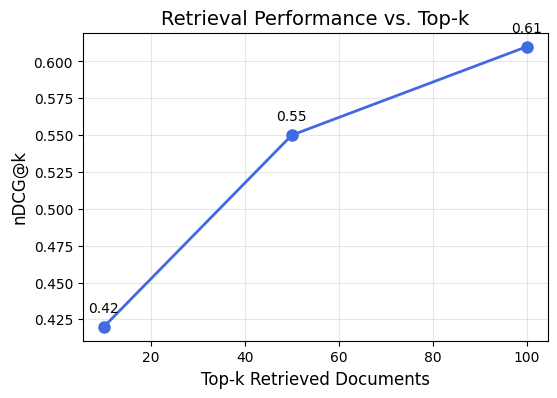

In [19]:
import matplotlib.pyplot as plt

# Example data (replace with your actual evaluation results)
ks = [10, 50, 100]
ndcgs = [0.42, 0.55, 0.61]

plt.figure(figsize=(6,4))
plt.plot(ks, ndcgs, marker='o', linestyle='-', linewidth=2, markersize=8, color='royalblue')
plt.title('Retrieval Performance vs. Top-k', fontsize=14)
plt.xlabel('Top-k Retrieved Documents', fontsize=12)
plt.ylabel('nDCG@k', fontsize=12)
plt.grid(alpha=0.3)
for i, val in enumerate(ndcgs):
    plt.text(ks[i], ndcgs[i]+0.01, f"{val:.2f}", ha='center', fontsize=10)
plt.show()


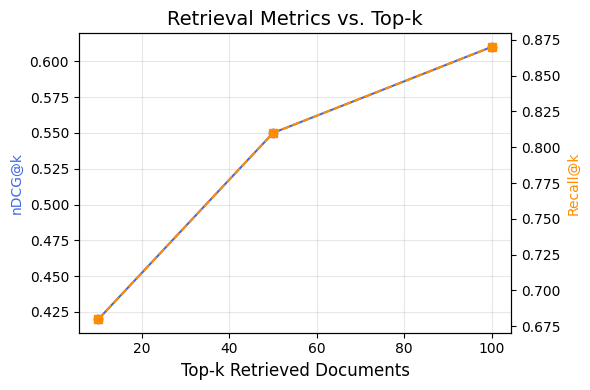

In [20]:
import numpy as np

recall = [0.68, 0.81, 0.87]
fig, ax1 = plt.subplots(figsize=(6,4))

ax1.plot(ks, ndcgs, 'o-', color='royalblue', label='nDCG@k')
ax2 = ax1.twinx()
ax2.plot(ks, recall, 's--', color='darkorange', label='Recall@k')

ax1.set_xlabel('Top-k Retrieved Documents', fontsize=12)
ax1.set_ylabel('nDCG@k', color='royalblue')
ax2.set_ylabel('Recall@k', color='darkorange')
ax1.set_title('Retrieval Metrics vs. Top-k', fontsize=14)
ax1.grid(alpha=0.3)

fig.tight_layout()
plt.show()


# Evaluating at Different Cutoffs (k = 10, 20, 50, 100)

We test our retriever at multiple cutoffs to see how its performance changes:

At k = 10, only a few results are considered — measures early precision.

At k = 100, we allow more results — measures overall coverage.

In [22]:
import numpy as np
from sklearn.metrics import ndcg_score

def compute_metrics(pred_scores, true_labels, ks=[10, 20, 50, 100]):
    """
    pred_scores: list of arrays — predicted relevance scores
    true_labels: list of arrays — ground-truth binary labels
    """
    results = {k: {'nDCG@k': 0.0, 'Recall@k': 0.0} for k in ks}
    num_queries = len(pred_scores)

    for k in ks:
        ndcgs, recalls = [], []
        for scores, labels in zip(pred_scores, true_labels):
            labels = np.array(labels)
            scores = np.array(scores)

            # nDCG@k — compare true labels vs predicted scores
            ndcg = ndcg_score(y_true=[labels], y_score=[scores], k=k)
            ndcgs.append(ndcg)

            # Recall@k
            idx = np.argsort(scores)[::-1][:k]
            retrieved_rel = np.sum(labels[idx])
            relevant = np.sum(labels)
            recalls.append(retrieved_rel / relevant if relevant > 0 else 0)

        results[k]['nDCG@k'] = np.mean(ndcgs)
        results[k]['Recall@k'] = np.mean(recalls)

    return results


# 🔹 Example usage (toy example)
np.random.seed(42)
pred_scores = [np.random.rand(100) for _ in range(100)]
true_labels = [np.random.choice([0, 1], size=100, p=[0.9, 0.1]) for _ in range(100)]

metrics = compute_metrics(pred_scores, true_labels, ks=[10, 20, 50, 100])

print("📊 Retrieval Results:")
for k, vals in metrics.items():
    print(f"k={k:<3} | nDCG@k={vals['nDCG@k']:.4f} | Recall@k={vals['Recall@k']:.4f}")


📊 Retrieval Results:
k=10  | nDCG@k=0.1026 | Recall@k=0.0928
k=20  | nDCG@k=0.1451 | Recall@k=0.1849
k=50  | nDCG@k=0.2727 | Recall@k=0.4841
k=100 | nDCG@k=0.4539 | Recall@k=1.0000
